`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2022/2023`   

In [3]:
# настройка ширины страницы блокнота .......................................
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# расширение watermark для вывода информации о версиях пакетов
#  https://github.com/rasbt/watermark
# установка: командная строка - pip install watermark
%load_ext watermark

C:\Users\user\AppData\Local\Temp\ipykernel_15704\3737213089.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Лабораторная работа №5: Методы, основанные на деревьях решений. Регрессионные деревья. Деревья классификации. Случайный лес. Бэггинг.  

В практических примерах ниже показано:   

* как делать перекодировку признаков в номинальной и порядковой шкалах
* как вырастить дерево и сделать обрезку его ветвей   
* как настроить модель бэггинга   
* как вырастить случайный лес
* как подбирать настроечные параметры моделей методом сеточного поиска  

Точность всех моделей оценивается методом перекрёстной проверки по 5 блокам.

In [5]:
# выводим информацию о версиях python и пакетов
%watermark -a "natasha" -d -v -p numpy,pandas,matplotlib,sklearn 

Author: natasha

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

numpy     : 1.21.5
pandas    : 1.4.4
matplotlib: 3.5.2
sklearn   : 1.1.1



# Указания к выполнению


## Загружаем пакеты

In [6]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# проверка существования файла на диске
from pathlib import Path
# для форматирования результатов с помощью Markdown
from IPython.display import Markdown, display
# перекодировка категориальных переменных
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# хи-квадрат тест на независимость по таблице сопряжённости
from scipy.stats import chi2_contingency
#  для таймера
import time

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  дерево классификации
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# бэггинг
from sklearn.ensemble import BaggingClassifier
# случайный лес
from sklearn.ensemble import RandomForestClassifier
# бустинг
from sklearn.ensemble import GradientBoostingClassifier
#  сводка по точности классификации
from sklearn.metrics import classification_report

In [7]:
# константы
#  ядро для генератора случайных чисел
my_seed = 14
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [8]:
# функция форматирования результатов с использованием Markdown
def printmd(string):
    display(Markdown(string))
    
# функции для попарной конкатенации элементов двух списков
concat_func_md = lambda x, y: '`' + str(x) + "`:&ensp;&ensp;&ensp;&ensp;" + str(y)
concat_func = lambda x, y: str(x) + ' ' * 4 + str(y)


# функция, которая строит график важности признаков в модели случайного леса
#  источник: https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
def plot_feature_importance(importance, names, model_type) :
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,
                      inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('Важность признаков в модели: ' + model_type)
    plt.xlabel('Важность признака')
    plt.ylabel('')

## Загружаем данные

In [9]:
# загружаем таблицу и превращаем её во фрейм
fileURL = 'https://raw.githubusercontent.com/ania607/ML/main/data/default_of_credit_card_clients.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (30000, 24)


In [10]:
# типы столбцов
DF_raw.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
Y            int64
dtype: object

Проблем нет. Все данные воспринимаются как `int`. Категориальные данные закодированны.

In [11]:
# первые 7 строк столбцов типа int64
DF_raw.loc[:, DF_raw.columns[DF_raw.dtypes == 'int64']].head(7)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,500000,1,1,2,29,0,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0


Функция построения дерева классификации `DecisionTreeClassifier()` требует числовых порядковых значений переменных. Видно, что столбцы типа `int64` либо порядковые (`temperature`), либо бинарные (все остальные), их преобразовывать нет необходимости.  

In [12]:
# меняем тип столбцов на категориальные
#for col in DF_raw.columns[DF_raw.dtypes == 'object'] :
#    DF_raw[col] = DF_raw[col].astype('category')

Отложим 15% наблюдений для прогноза.  

In [13]:
# наблюдения для моделирования
DF = DF_raw.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_raw.drop(DF.index)

# Предварительный анализ данных  

## Описательные статистики  

Стандартный подсчёт статистик с помощью фунции `describe()`.  

In [14]:
# метки классов
DF.Y.unique()

array([0, 1], dtype=int64)

In [15]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 5)

0    0.77749
1    0.22251
Name: Y, dtype: float64

In [16]:
# описательные статистики
DF.iloc[:, :].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
count,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,...,25500.000000,25500.000000,25500.000000,25500.000000,2.550000e+04,25500.000000,25500.000000,25500.000000,25500.000000,25500.00000
mean,167563.516863,1.602392,1.854824,1.551333,35.469882,-0.018706,-0.133294,-0.165137,-0.220510,-0.263882,...,43177.714392,40194.415451,38775.580980,5640.161451,5.905967e+03,5169.580157,4812.683451,4747.400118,5129.736980,0.22251
std,129692.809865,0.489413,0.791057,0.521990,9.210737,1.124963,1.199107,1.200703,1.173773,1.142866,...,64408.990455,60732.087927,59536.248091,16772.902744,2.379707e+04,17864.453910,15607.831191,15252.544831,16762.422079,0.41594
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2294.000000,1727.750000,1242.000000,991.000000,8.167500e+02,390.000000,291.000000,241.750000,102.000000,0.00000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,18991.000000,18067.000000,17008.500000,2100.000000,2.008000e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.00000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54275.000000,50141.750000,49110.500000,5006.000000,5.000000e+03,4500.000000,4009.250000,4002.000000,4000.000000,0.00000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,443001.000000,1.00000


In [17]:
# считаем пропуски в столбцах, выводим ненулевые значения
nas = DF.isna().sum()
nas = np.around(nas / DF.shape[0], 3)
nas[nas > 0]

Series([], dtype: float64)

Пропусков нет.  

## Распределение предикторов внутри классов  по зависимой переменной

Все объясняющие переменные являются категориальными, поэтому оценивать их связь с зависимой переменной с помощью корреляционной матрицы некорректно. Вместо этого можно воспользоваться [критерием согласия Хи-квадрат](https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D1%81%D0%BE%D0%B3%D0%BB%D0%B0%D1%81%D0%B8%D1%8F_%D0%9F%D0%B8%D1%80%D1%81%D0%BE%D0%BD%D0%B0), который рассчитывается по таблице сопряжённости. Нулевая гипотеза теста: распределение долей в таблице сопряжённости случайно, т.е. два показателя независимы друг от друга.     
Проведём тест для всех пар "объясняющая переменная" – "зависимая переменная" и выведем те пары, для которых соответствующее критерию p-значение больше 0.05 (т.е. нулевая гипотеза принимается, переменные независимы).  

In [18]:
for col in DF.columns[:24] :
    con_tab = pd.crosstab(DF[col], DF['Y'])
    c, p, dof, expected = chi2_contingency(con_tab)
    if p > 0.05 :
        print(col, 'и Y',
              '\nH_0: переменные распределены независимо друг от друга', 
              '\nP-значение:', np.around(p, 4))

BILL_AMT1 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 0.7187
BILL_AMT2 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 0.7449
BILL_AMT3 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 0.6343
BILL_AMT4 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 0.5643
BILL_AMT5 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 0.5969
BILL_AMT6 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 0.5582
PAY_AMT1 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 1.0
PAY_AMT2 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 1.0
PAY_AMT3 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 1.0
PAY_AMT4 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 1.0
PAY_AMT5 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 1.0
PAY_AMT6 и Y 
H_0: переменные распределен

Интересный результат: полное совпадение p-значений – объясняется тем, что на самом деле `PAY_AMT6`, `PAY_AMT5`, `PAY_AMT4`, `PAY_AMT3`, `PAY_AMT2`, `PAY_AMT1` противоположны друг другу. Связь между ними функциональная: если направление на статуса платежа не совпадает с направлением на исходное место назначения (`PAY_AMT6 == 1`), то оно противоположно (`PAY_AMT6 == -1`), и наоборот. Поэтому в модель имело бы смысл включать только одну из, так и сделаем, однако стоит учитывать что P-значение равно 1, слишком много, смысла огромного нет.  

In [19]:
# исключаем direction_opp 
#  из обучающей выборки
DF = DF.drop(['PAY_AMT6', 'PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2'], axis=1)
#  и из отложенных наблюдений
DF_predict = DF_predict.drop(['PAY_AMT6', 'PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2'], axis=1)

## Перекодировка номинальной и порядковой шкалы   

Перекодировка не треубуется так как исходные данные уже заходированы.  

In [20]:
# чтобы меньше исправлять
DF_num = DF

# результат
DF_num.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,Y
6947,150000,1,3,1,64,0,0,0,0,0,0,56852,58031,59202,60304,61650,0,2688,0
24408,620000,1,2,1,42,0,0,0,0,0,0,75509,65572,59306,60479,61467,63159,3500,0
11085,180000,2,2,2,34,0,0,0,0,0,0,59076,50505,38547,63249,51437,45279,3000,0
21625,80000,2,2,2,24,0,0,0,0,0,-1,13118,11622,12011,3210,1651,2256,1500,0
3207,390000,1,1,2,34,-1,-1,-1,-1,-1,-1,13006,522,1790,7957,3044,27603,524,0


In [21]:
# чтоб меньше исправлять
DF_predict_num = DF_predict

# результат
DF_predict_num.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,Y
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,0
12,630000,2,2,2,41,-1,0,-1,-1,-1,-1,12137,6500,6500,6500,6500,2870,1000,0
15,50000,2,3,3,23,1,2,0,0,0,0,50614,29173,28116,28771,29531,30211,0,0
22,70000,2,2,2,26,2,0,0,2,2,2,41087,42445,45020,44006,46905,46012,2007,1
34,500000,1,1,1,58,-2,-2,-2,-2,-2,-2,13709,5006,31130,3180,0,5293,5006,0


# Модель дерева  

В этом разделе построим:  

* дерево классификации  
* дерево классификации с обрезкой ветвей  


## Дерево на всех признаках    

Построим модель и выведем изображение дерева в виде текста.  

In [22]:
# выращиваем дерево на всех объясняющих
X = DF_num.drop(['Y'], axis=1)
y = DF_num['Y']

# классификатор
cls_one_tree = DecisionTreeClassifier(criterion='entropy',
                                      random_state=my_seed)

tree_full = cls_one_tree.fit(X, y)

# выводим количество листьев (количество конечных узлов)
tree_full.get_n_leaves()

3998

In [23]:
# глубина дерева: количество узлов от корня до листа
#  в самой длинной ветви
tree_full.get_depth()

55

Очевидно, дерево получилось слишком большое для отображения в текстовом формате. Графическая визуализация тоже не поможет в данном случае. Посчитаем показатели точности с перекрёстной проверкой.   

In [24]:
# будем сохранять точность моделей в один массив:
score = list()
score_models = list()

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=cls_one_tree, X=X, y=y, cv=5,
                     scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('one_tree')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[0], ':', score[0])

Acc с перекрёстной проверкой 
для модели one_tree : 0.727


## Дерево с обрезкой ветвей   

Подберём оптимальное количество ветвей, которое максимизирует $Acc$, для экономии времени рассчитанный методом проверочной выборки.  

In [25]:
# рассчитываем параметры alpha для эффективных вариантов обрезки ветвей
path = cls_one_tree.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print('Всего значений alpha:', len(ccp_alphas))
print('Энтропия листьев для первых 5 значений alpha:', impurities[:5])

Всего значений alpha: 1666
Энтропия листьев для первых 5 значений alpha: [0.00137332 0.00140292 0.00143644 0.00145566 0.00148135]


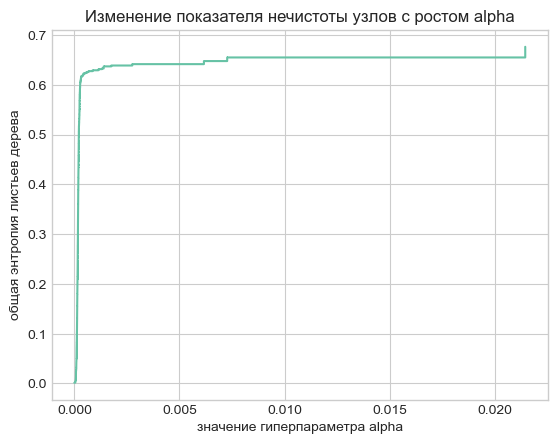

In [26]:
# изображаем на графике
plt.plot(ccp_alphas[:-1], impurities[:-1], marker=',', drawstyle="steps-post")
plt.xlabel("значение гиперпараметра alpha")
plt.ylabel("общая энтропия листьев дерева")
plt.title("Изменение показателя нечистоты узлов с ростом alpha")
plt.show()

In [27]:
# обучающая и тестовая выборки, чтобы сэкономить время
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=my_seed)

# модели
clfs = list()

# таймер
tic = time.perf_counter()
# цикл по значениям alpha
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=my_seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# таймер
toc = time.perf_counter()
print(f"Расчёты по обрезке дерева заняли {toc - tic:0.2f} секунд")

Расчёты по обрезке дерева заняли 725.14 секунд


In [28]:
# извлекаем характеристики глубины и точности
#  таймер
tic = time.perf_counter()
node_counts = [clf.tree_.node_count for clf in clfs]
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
#  таймер
toc = time.perf_counter()
print(f"Расчёты показателей точности заняли {toc - tic:0.2f} секунд")

Расчёты показателей точности заняли 24.11 секунд


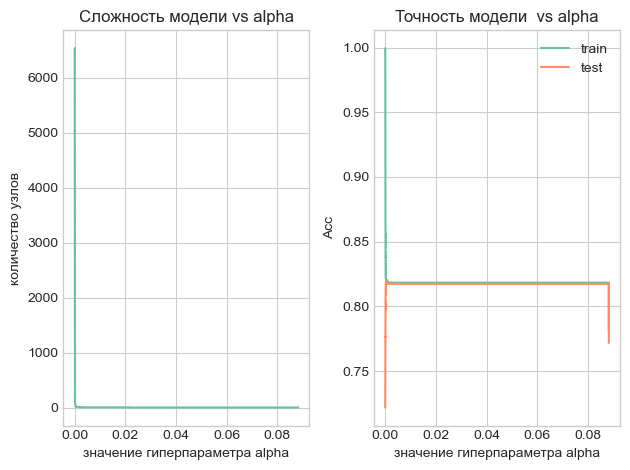

In [29]:
# изображаем на графике
fig, ax = plt.subplots(1, 2)

# график глубины дерева
ax[0].plot(ccp_alphas, node_counts, marker=',', drawstyle="steps-post")
ax[0].set_xlabel("значение гиперпараметра alpha")
ax[0].set_ylabel("количество узлов")
ax[0].set_title("Сложность модели vs alpha")

# график точности
ax[1].plot(ccp_alphas, train_scores, marker=',', label='train',
           drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores, marker=',', label='test',
           drawstyle="steps-post")
ax[1].set_xlabel("значение гиперпараметра alpha")
ax[1].set_ylabel("Acc")
ax[1].set_title("Точность модели  vs alpha")
ax[1].legend()
fig.tight_layout()

Находим оптимальный размер дерева по максимуму $Acc$ на тестовой выборке.  

In [30]:
# оптимальное количество узлов
opt_nodes_num = node_counts[test_scores.index(max(test_scores))]

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=clfs[opt_nodes_num], X=X, y=y, cv=5,
                    scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('pruned_tree')

print('Оптимальное количество узлов:', opt_nodes_num,
      '\nсоответствующая Acc на тестовой:', np.around(max(test_scores), 3),
      '\n\nAcc с перекрёстной проверкой',
      '\nдля модели', score_models[1], ':', score[1])

Оптимальное количество узлов: 35 
соответствующая Acc на тестовой: 0.82 

Acc с перекрёстной проверкой 
для модели pruned_tree : 0.738


Посмотрим на характеристики глубины и сложности построенного дерева с обрезкой ветвей.

In [31]:
# выводим количество листьев (количество узлов)
clfs[opt_nodes_num].get_n_leaves()

2372

In [32]:
# глубина дерева: количество узлов от корня до листа
#  в самой длинной ветви
clfs[opt_nodes_num].get_depth()

44

---

📚 **Пример визуализации небольшого дерева**

Лучшее дерево с обрезкой по-прежнему слишком велико для визуализации. Для примера нарисуем одно из небольших деревьев с обрезкой и выведем его же в виде текста.  

In [33]:
# находим деревья с количеством листьев меньше 25
[i for i in node_counts if i < 25]

[23,
 23,
 23,
 21,
 21,
 19,
 17,
 15,
 15,
 15,
 13,
 13,
 13,
 13,
 13,
 11,
 11,
 11,
 9,
 9,
 7,
 5,
 5,
 3,
 1]

In [34]:
plot_tree?

Количество узлов: 25 
Точность дерева на тестовой: 0.82


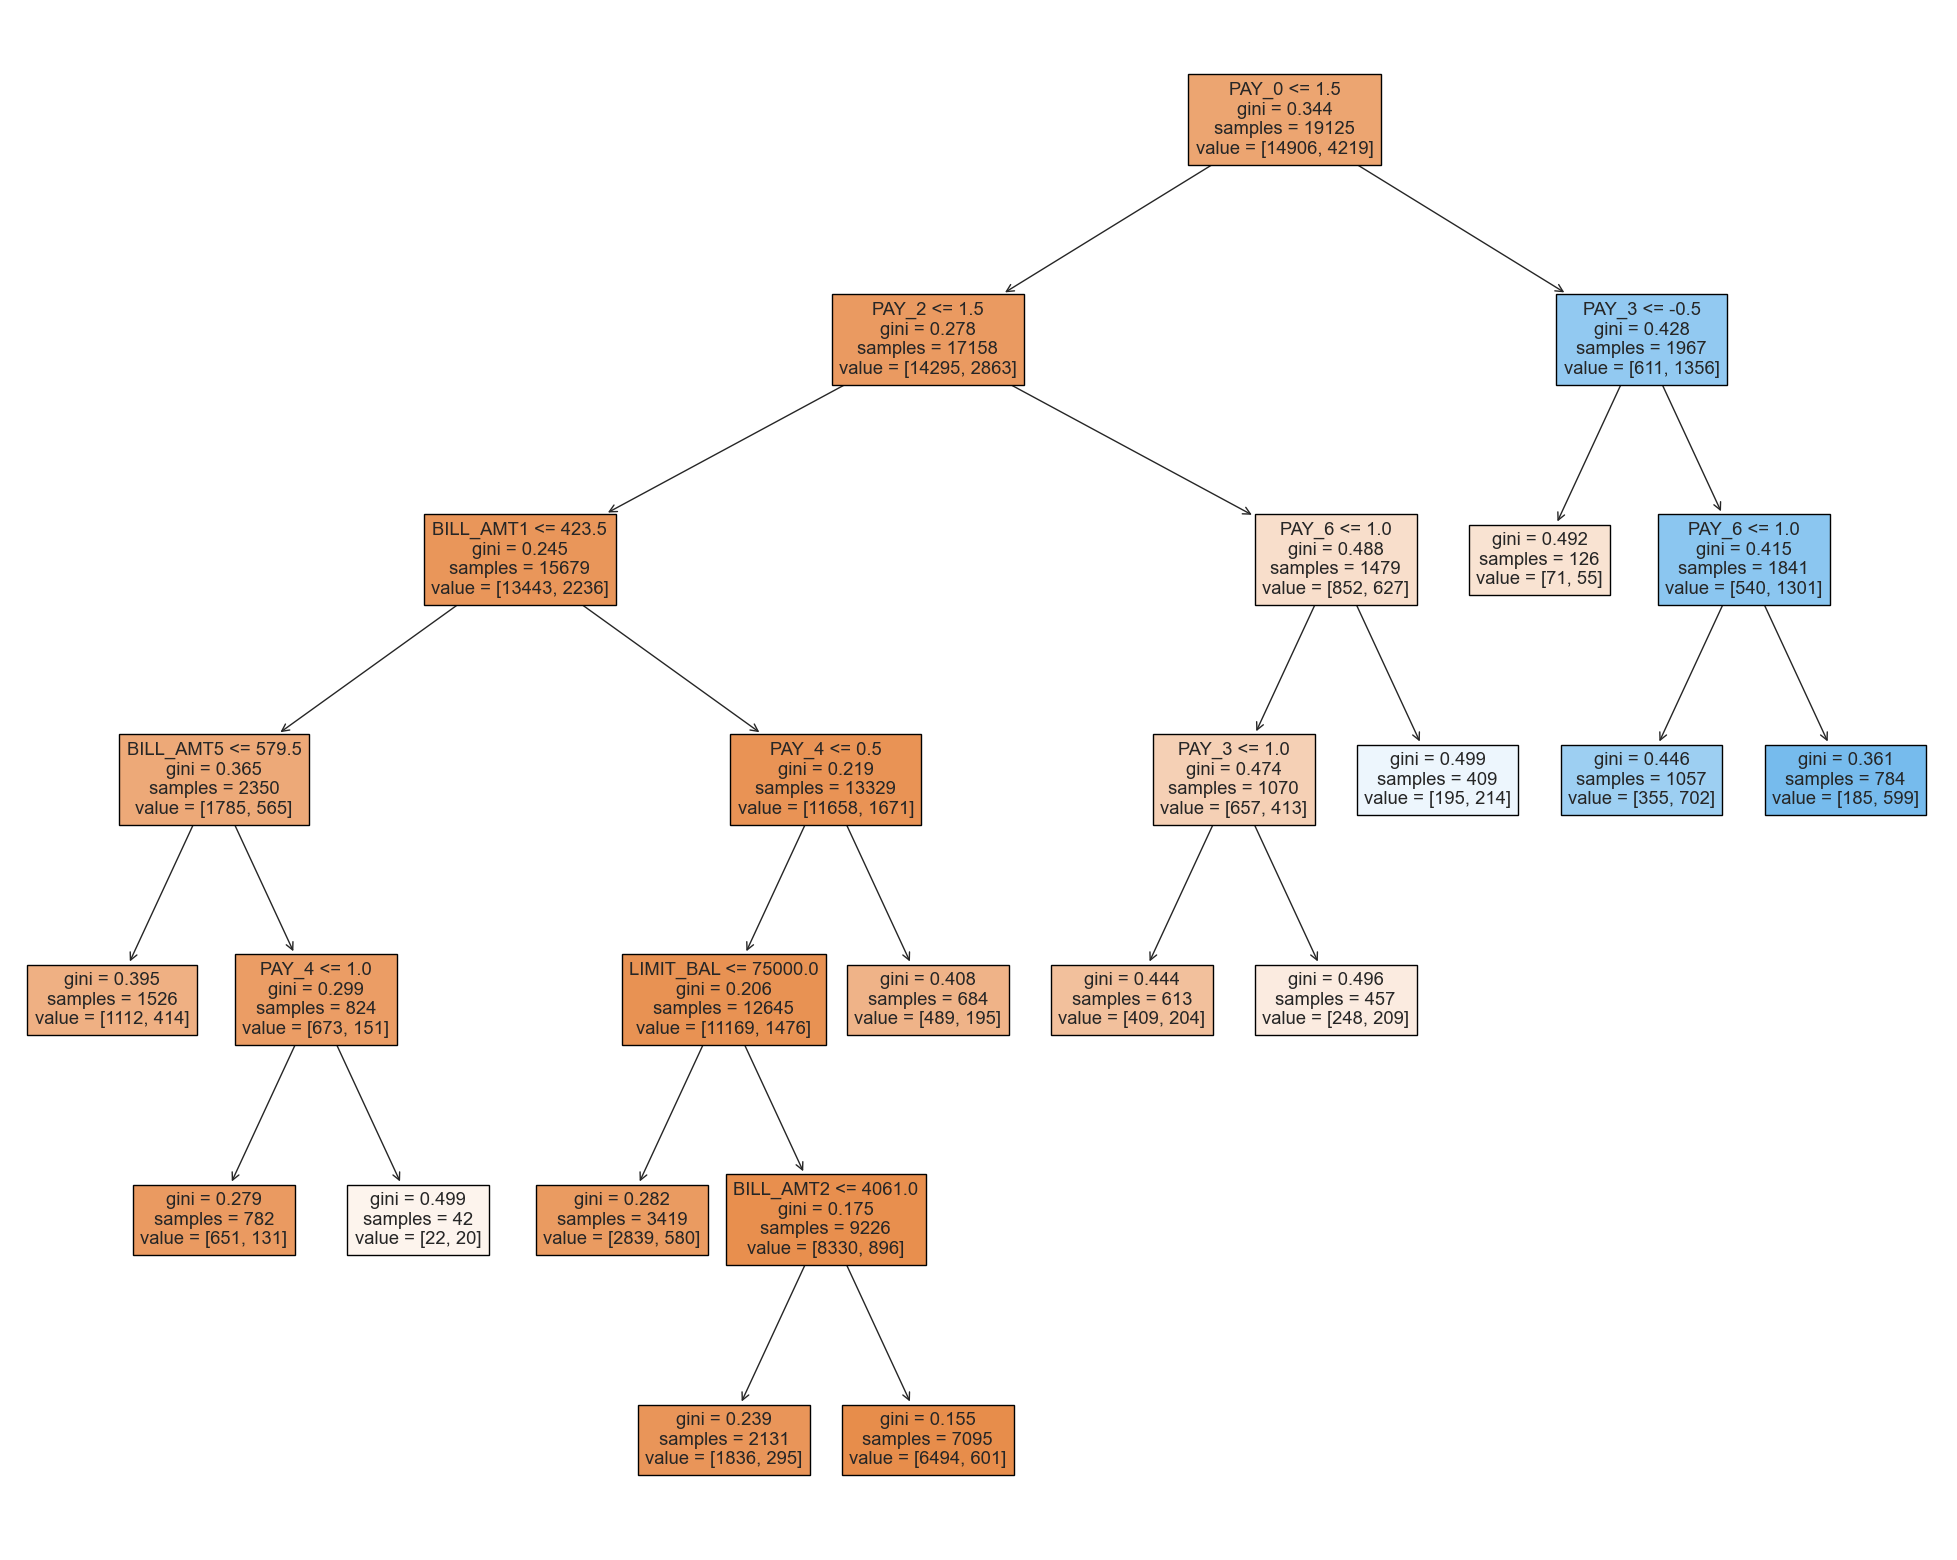

In [35]:
# визуализация на схеме НА ПРИМЕРЕ МАЛЕНЬКОГО ДЕРЕВА
nodes_num = len([i for i in node_counts if i < 25])
print('Количество узлов:', nodes_num,
      '\nТочность дерева на тестовой:', 
      np.around(test_scores[node_counts.index(nodes_num)], 3))

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clfs[node_counts.index(nodes_num)], 
              filled=True, 
              feature_names=list(X.columns))

In [36]:
# визуализируем дерево в виде текстовой схемы
viz = export_text(clfs[node_counts.index(nodes_num)], 
                  feature_names=list(X.columns))
print(viz)

|--- PAY_0 <= 1.50
|   |--- PAY_2 <= 1.50
|   |   |--- BILL_AMT1 <= 423.50
|   |   |   |--- BILL_AMT5 <= 579.50
|   |   |   |   |--- class: 0
|   |   |   |--- BILL_AMT5 >  579.50
|   |   |   |   |--- PAY_4 <= 1.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- PAY_4 >  1.00
|   |   |   |   |   |--- class: 0
|   |   |--- BILL_AMT1 >  423.50
|   |   |   |--- PAY_4 <= 0.50
|   |   |   |   |--- LIMIT_BAL <= 75000.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- LIMIT_BAL >  75000.00
|   |   |   |   |   |--- BILL_AMT2 <= 4061.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- BILL_AMT2 >  4061.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- PAY_4 >  0.50
|   |   |   |   |--- class: 0
|   |--- PAY_2 >  1.50
|   |   |--- PAY_6 <= 1.00
|   |   |   |--- PAY_3 <= 1.00
|   |   |   |   |--- class: 0
|   |   |   |--- PAY_3 >  1.00
|   |   |   |   |--- class: 0
|   |   |--- PAY_6 >  1.00
|   |   |   |--- class: 1
|--- PAY_0 >  1.50
|   |--- PAY_3 <= -0.50
| 

# Случайный лес  



У модели случайного леса два настроечных параметра: количество деревьев $B$ и количество признаков для построения отдельного дерева $m$. Настроим сеточный поиск для их подбора.  

In [37]:
# сколько столбцов в обучающих данных (p)
X_m = X.shape[1]
# возьмём значения для m: p, p/2, sqrt(p) и log2(p)
ms = np.around([X_m, X_m / 2, np.sqrt(X_m), np.log2(X_m)]).astype(int)
ms

array([18,  9,  4,  4])

In [41]:
# настроим параметры случайного леса с помощью сеточного поиска
param_grid = {'n_estimators' : [5, 10, 15, 25, 30, 40, 50, 60],
              'max_features' : ms}

# разбиения для перекрёстной проверки
kfold = KFold(n_splits=5, random_state=my_seed, shuffle=True)

# таймер
tic = time.perf_counter()
clf = GridSearchCV(RandomForestClassifier(DecisionTreeClassifier()),
                   param_grid, scoring='accuracy', cv=kfold)
random_forest = clf.fit(X, y)
# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 526.18 секунд


In [47]:
# точность лучшей модели
np.around(random_forest.best_score_, 3)

0.812

In [48]:
# количество деревьев у лучшей модели
random_forest.best_estimator_.get_params()['n_estimators']

60

In [49]:
# количество объясняющих у лучшей модели
random_forest.best_estimator_.get_params()['max_features']

4

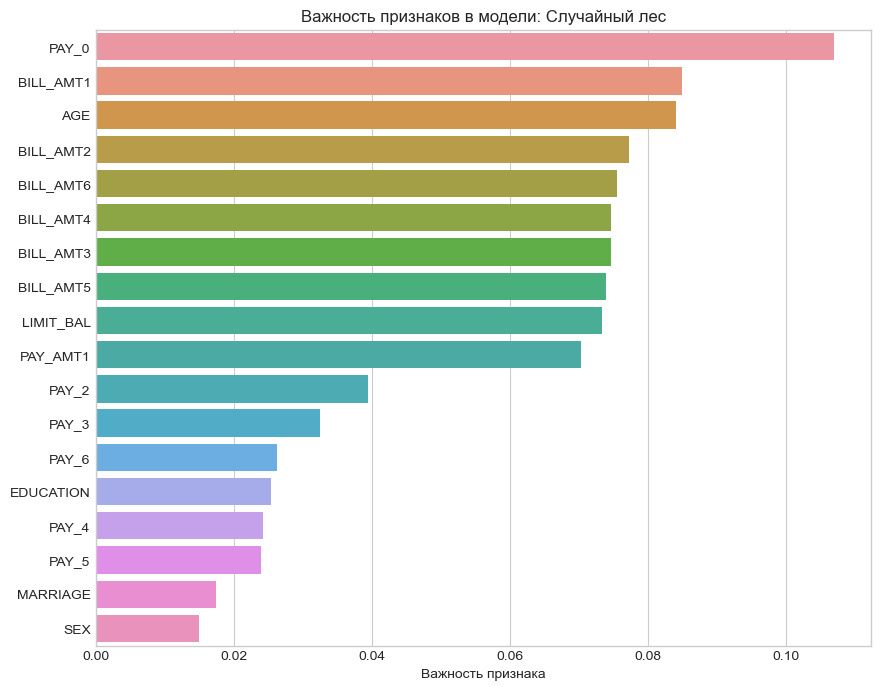

In [50]:
# рисуем график относительной важности каждого признака
plot_feature_importance(random_forest.best_estimator_.feature_importances_,
                        X.columns, 'Случайный лес')

In [57]:
# записываем точность
score.append(np.around(random_forest.best_score_, 3))
score_models.append('random_forest_GS')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[3], ':', score[3])

Acc с перекрёстной проверкой 
для модели random_forest_GS : 0.812



# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [58]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,one_tree,0.727
1,pruned_tree,0.738
2,random_forest_GS,0.812
3,random_forest_GS,0.812
4,random_forest_GS,0.812
5,random_forest_GS,0.812
6,random_forest_GS,0.812


Все модели показывают среднюю точность по показателю $Acc$, при этом самой точной оказывается модель случайного леса. Сделаем прогноз на отложенные наблюдения.   

In [59]:
# данные для прогноза
X_pred = DF_predict_num.drop(['Y'], axis=1)
# строим прогноз
y_hat = random_forest.best_estimator_.predict(X_pred)
# характеристики точности
print(classification_report(DF_predict_num['Y'], y_hat))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      3538
           1       0.65      0.37      0.47       962

    accuracy                           0.82      4500
   macro avg       0.75      0.66      0.68      4500
weighted avg       0.80      0.82      0.80      4500

